# Sheridan Kamal

## DATA 73500 - Final Project

### Project
For my project, I will be using machine learning methods to predict recessions. I will first create a dataset from a list of features (some of which are transformed) and then split the dataset into training and testing sets using the hold-out validation method. The training and testing sets will be used for machine learning models for my predictions. I will be creating Logistic Regression models with scaled and unscaled data and Decision Tree Classifier models with scaled and unscaled data. The best Logistic Regression model using this method is the model with the scaled data the best Decision Tree Classifier model using this method is the model with the data as well. I have also split the data using the walk foward cross validation method with 5 iterations and used this method in conjuction with the previous models to determine if it would improve the model's accuracy. The best Logistic Regression model using this method is the model with the scaled data the best Decision Tree Classifier model using this method is the model with the scaled data as well. Both of the models using the walk foward cross validation method had a higher accuracy than the models using the hold-out validation method.

### Data
Since the features I needed for my dataset were not conveniently included in a downloadable dataset, I had to download each feature separately and combine them together into one dataframe. I was able to pull each economic feature separately from FRED (Federal Reserve Economic Data from the Federal Reserve Bank of St. Louis) using Quandl, which also had the added bonus of automatically calculating selected transformations if I chose to do so, and the financial feature was downloadable from Yahoo! Finance so I downloaded the dataset and created the transformed variables in Excel and imported the dataset as a CSV. I created Recession labels from a list of start and end dates. I then concated each feature and the labels using an inner join to create one dataframe. After creating a correlation heatmap, I selected the features I wanted to include in my final dataset (each of the features fall under a certain category; employment, monetary policy, inflation, bond market, or stock market). I then saved this dataset as a CSV and performed some descriptive statistics on the data. Finally, I created training and testing sets using train_test_split with no shuffling.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import quandl as qnd

tbond_10yr = qnd.get('FRED/GS10')
tbond_10yr_pchange = qnd.get('FRED/GS10', transformation = "rdiff") #Percent change transformation
spread_2yr = qnd.get('FRED/T10Y2YM')
fedrate = qnd.get('FRED/FEDFUNDS')
fedrate_pchange = qnd.get('FRED/FEDFUNDS', transformation = "rdiff") #Percent change transformation
nonfarm_payrolls = qnd.get('FRED/PAYEMS')
nonfarm_payrolls_pchange = qnd.get('FRED/PAYEMS', transformation = "rdiff") #Percent change transformation
cpi = qnd.get('FRED/CPIAUCSL')
cpi_pchange = qnd.get('FRED/CPIAUCSL', transformation = "rdiff") #Percent change transformation
snp_500 = pd.read_csv('S&P 500 Index.csv', sep = ',', parse_dates = ['Date'], index_col = 'Date') #Four columns of percent change transformations
recessions = {'1': {'Begin': '1957-08-01', 'End': '1958-04-01'}, 
              '2': {'Begin': '1960-04-01', 'End': '1961-02-01'}, 
              '3': {'Begin': '1969-12-01', 'End': '1970-11-01'}, 
              '4': {'Begin': '1973-11-01', 'End': '1975-03-01'}, 
              '5': {'Begin': '1980-01-01', 'End': '1980-07-01'}, 
              '6': {'Begin': '1981-07-01', 'End': '1982-11-01'}, 
              '7': {'Begin': '1990-07-01', 'End': '1991-03-01'}, 
              '8': {'Begin': '2001-03-01', 'End': '2001-11-01'}, 
              '9': {'Begin': '2007-12-01', 'End': '2009-06-01'}}

In [2]:
for recession in recessions:
    end_condition = (recessions[recession]['End'] >= snp_500.index)
    begin_condition = (snp_500.index >= recessions[recession]['Begin'])
    snp_500.loc[end_condition & begin_condition, 'Recession'] = 1

snp_500['Recession'].fillna(0, inplace = True)
snp_500.head()

Close   1 Month  3 Months  6 Months  12 Months  Recession
Date                                                                     
1927-12-01  17.660000       NaN       NaN       NaN        NaN        0.0
1928-01-01  17.570000 -0.005109       NaN       NaN        NaN        0.0
1928-02-01  17.260000 -0.017801       NaN       NaN        NaN        0.0
1928-03-01  19.280001  0.110677  0.087766       NaN        NaN        0.0
1928-04-01  19.750000  0.024085  0.116961       NaN        NaN        0.0

In [3]:
df = pd.concat([tbond_10yr, tbond_10yr_pchange, spread_2yr, fedrate, fedrate_pchange, nonfarm_payrolls, nonfarm_payrolls_pchange, cpi, cpi_pchange, snp_500], axis = 1, join = 'inner')
df.columns = ['10yr Tbond', '% Change Tbond', '2yr Spread', 'Fedrate', '% Change Fedrate', 'Nonfarm Payrolls', '% Change Payrolls', 'CPI', '% Change CPI', 'S&P 500', '% Change 1M', '% Change 3M', '% Change 6M', '% Change 12M', 'Recession']
df.head()

10yr Tbond  % Change Tbond  2yr Spread  Fedrate  % Change Fedrate  \
Date                                                                            
1976-06-01        7.86       -0.005063        0.80     5.48          0.035917   
1976-07-01        7.83       -0.003817        0.98     5.31         -0.031022   
1976-08-01        7.77       -0.007663        1.14     5.29         -0.003766   
1976-09-01        7.59       -0.023166        1.17     5.25         -0.007561   
1976-10-01        7.41       -0.023715        1.43     5.02         -0.043810   

            Nonfarm Payrolls  % Change Payrolls   CPI  % Change CPI  \
Date                                                                  
1976-06-01           79376.0           0.000807  56.7      0.005319   
1976-07-01           79547.0           0.002154  57.0      0.005291   
1976-08-01           79704.0           0.001974  57.3      0.005263   
1976-09-01           79892.0           0.002359  57.6      0.005236   
1976-10-01           79911.0           0.000238  57.9      0.005208   

               S&P 500  % Change 1M  % Change 3M  % Change 6M  % Change 12M  \
Date                                                                          
1976-06-01  104.279999     0.040111     0.014586     0.145161      0.091205   
1976-07-01  103.440002    -0.008088     0.017555     0.025258      0.153168   
1976-08-01  102.910004    -0.005137     0.026886     0.031589      0.169327   
1976-09-01  105.239998     0.022389     0.009164     0.023750      0.226975   
1976-10-01  102.900002    -0.022486    -0.005234     0.012321      0.144672   

            Recession  
Date                   
1976-06-01        0.0  
1976-07-01        0.0  
1976-08-01        0.0  
1976-09-01        0.0  
1976-10-01        0.0

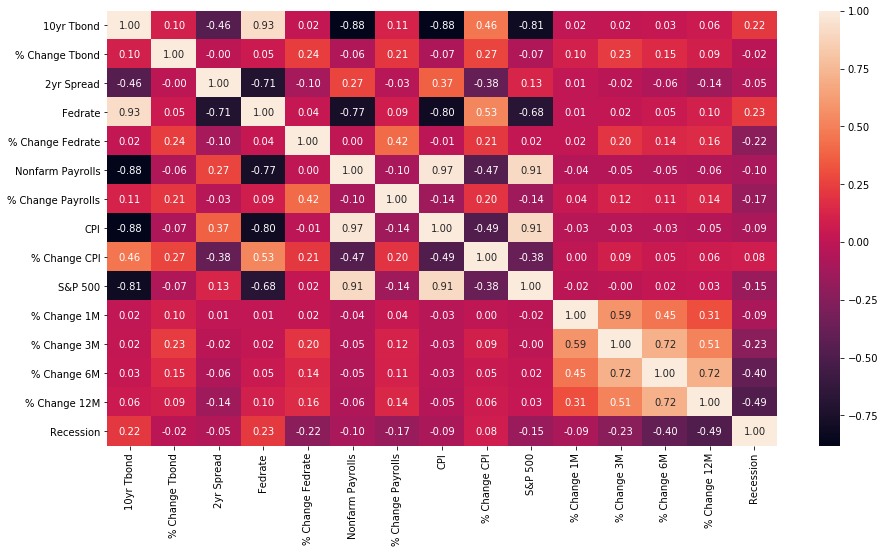

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.figure(figsize = (15, 8))
sns.heatmap(df.corr(), annot = True, fmt = ".2f")

In [5]:
data = pd.concat([tbond_10yr, spread_2yr, fedrate, nonfarm_payrolls_pchange, cpi, snp_500['12 Months'], snp_500['Recession']], axis = 1, join = 'inner')
data.columns = ['10yr Tbond', '2yr Spread', 'Fedrate', '% Change Payrolls', 'CPI', '% Change 12M', 'Recession']
data.to_csv('Project Dataset.csv')

In [6]:
#data = pd.read_csv('Project Dataset.csv', sep = ',', parse_dates = ['Date'], index_col = 'Date')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 527 entries, 1976-06-01 to 2020-04-01
Freq: MS
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   10yr Tbond         527 non-null    float64
 1   2yr Spread         527 non-null    float64
 2   Fedrate            527 non-null    float64
 3   % Change Payrolls  527 non-null    float64
 4   CPI                527 non-null    float64
 5   % Change 12M       527 non-null    float64
 6   Recession          527 non-null    float64
dtypes: float64(7)
memory usage: 32.9 KB


In [8]:
data['Recession'].value_counts()

0.0    466
1.0     61
Name: Recession, dtype: int64

In [9]:
data.iloc[:, :-1].describe() #No need to include the Recession lables

10yr Tbond  2yr Spread     Fedrate  % Change Payrolls         CPI  \
count  527.000000  527.000000  527.000000         527.000000  527.000000   
mean     6.177287    0.931366    4.890266           0.000975  163.281934   
std      3.258870    0.912993    4.039102           0.006252   57.315716   
min      0.660000   -2.130000    0.050000          -0.135484   56.700000   
25%      3.565000    0.245000    1.280000           0.000441  113.250000   
50%      5.810000    0.860000    4.950000           0.001387  162.600000   
75%      8.210000    1.595000    6.910000           0.002251  216.185000   
max     15.320000    2.830000   19.100000           0.012404  259.050000   

       % Change 12M  
count    527.000000  
mean       0.078462  
std        0.152531  
min       -0.593415  
25%        0.012679  
50%        0.101643  
75%        0.172694  
max        0.424890

In [10]:
#For hold out validation
from sklearn.model_selection import train_test_split

X = data.iloc[:, 0:-1]
y = data.loc[:, 'Recession']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, shuffle=False, random_state=1)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logpredict = logreg.predict(X_test)

print("Unscaled Logistic Regression Accuracy: {:.2f}%".format(logreg.score(X_test, y_test)*100))
print(classification_report(y_test, logpredict, target_names=['No', 'Yes']))

Unscaled Logistic Regression Accuracy: 88.05%
              precision    recall  f1-score   support

          No       0.88      1.00      0.94       140
         Yes       0.00      0.00      0.00        19

    accuracy                           0.88       159
   macro avg       0.44      0.50      0.47       159
weighted avg       0.78      0.88      0.82       159



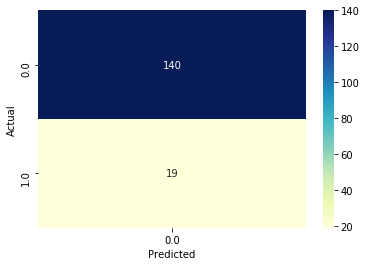

In [12]:
confusion_matrix = pd.crosstab(y_test, logpredict, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="YlGnBu")

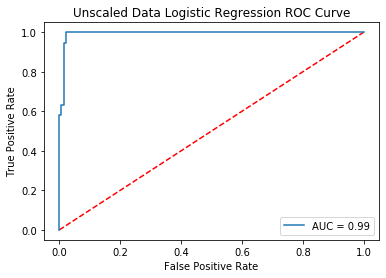

In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logreg_roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % logreg_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Unscaled Data Logistic Regression ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

steps = [('scaler', StandardScaler()),
        ('LogReg', LogisticRegression())]

pipeline = Pipeline(steps)

pipeline.fit(X_train, y_train)

logpredict_scaled = pipeline.predict(X_test)

print("Scaled Logistic Regression Accuracy: {:.2f}%".format(pipeline.score(X_test, y_test)*100))
print(classification_report(y_test, logpredict_scaled, target_names=['No', 'Yes']))

Scaled Logistic Regression Accuracy: 93.08%
              precision    recall  f1-score   support

          No       0.94      0.98      0.96       140
         Yes       0.79      0.58      0.67        19

    accuracy                           0.93       159
   macro avg       0.87      0.78      0.81       159
weighted avg       0.93      0.93      0.93       159



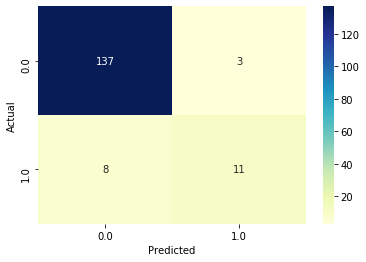

In [15]:
confusion_matrix = pd.crosstab(y_test, logpredict_scaled, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="YlGnBu")

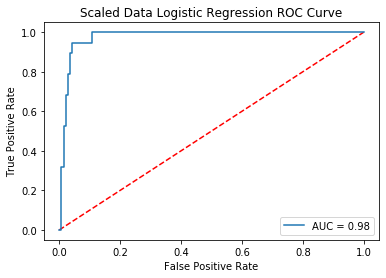

In [16]:
y_pred_prob_scaled = pipeline.predict_proba(X_test)[:,1]

logreg_scaled_roc_auc = roc_auc_score(y_test, y_pred_prob_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_scaled)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % logreg_scaled_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Scaled Data Logistic Regression ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [17]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

tree.fit(X_train, y_train)

treepredict = tree.predict(X_test)

print("Unscaled Decision Tree Accuracy: {:.2f}%".format(tree.score(X_test, y_test)*100))
print(classification_report(y_test, treepredict, target_names=['No', 'Yes']))

Unscaled Decision Tree Accuracy: 89.94%
              precision    recall  f1-score   support

          No       0.91      0.99      0.95       140
         Yes       0.71      0.26      0.38        19

    accuracy                           0.90       159
   macro avg       0.81      0.62      0.66       159
weighted avg       0.88      0.90      0.88       159



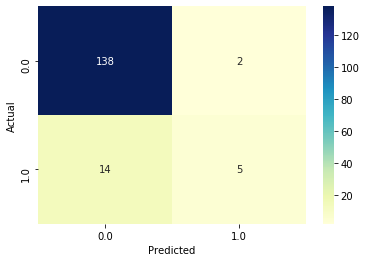

In [18]:
confusion_matrix = pd.crosstab(y_test, treepredict, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="YlGnBu")

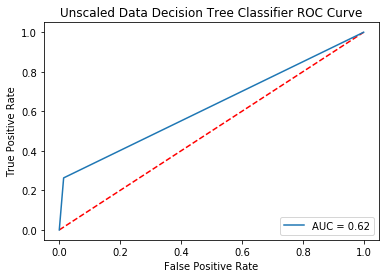

In [19]:
y_pred_prob = tree.predict_proba(X_test)[:,1]

tree_roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % tree_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Unscaled Data Decision Tree Classifier ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [20]:
steps = [('scaler', StandardScaler()),
        ('tree', DecisionTreeClassifier())]

pipeline = Pipeline(steps)

pipeline.fit(X_train, y_train)

treepredict_scaled = pipeline.predict(X_test)

print("Scaled Logistic Regression Accuracy: {:.2f}%".format(pipeline.score(X_test, y_test)*100))
print(classification_report(y_test, treepredict_scaled, target_names=['No', 'Yes']))

Scaled Logistic Regression Accuracy: 91.82%
              precision    recall  f1-score   support

          No       0.93      0.99      0.96       140
         Yes       0.80      0.42      0.55        19

    accuracy                           0.92       159
   macro avg       0.86      0.70      0.75       159
weighted avg       0.91      0.92      0.91       159



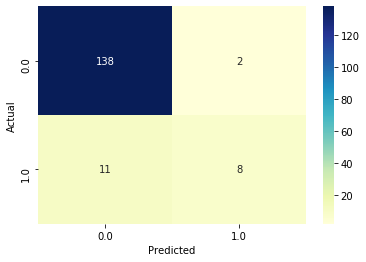

In [21]:
confusion_matrix = pd.crosstab(y_test, treepredict_scaled, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="YlGnBu")

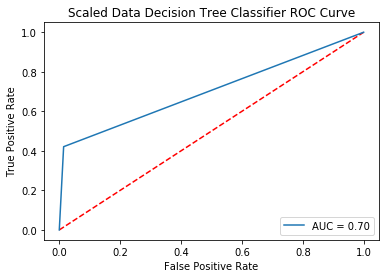

In [22]:
y_pred_prob_scaled = pipeline.predict_proba(X_test)[:,1]

tree_scaled_roc_auc = roc_auc_score(y_test, y_pred_prob_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_scaled)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = %0.2f' % tree_scaled_roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Scaled Data Decision Tree Classifier ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [23]:
#For walk foward cross validation
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

index = 1
for train_index, test_index in tscv.split(X):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    print('Split %d.' % index, 'Training set observations: %d,' % len(train_index), 'Testing set observations: %d' % len(test_index))
    index += 1

Split 1. Training set observations: 92, Testing set observations: 87
Split 2. Training set observations: 179, Testing set observations: 87
Split 3. Training set observations: 266, Testing set observations: 87
Split 4. Training set observations: 353, Testing set observations: 87
Split 5. Training set observations: 440, Testing set observations: 87


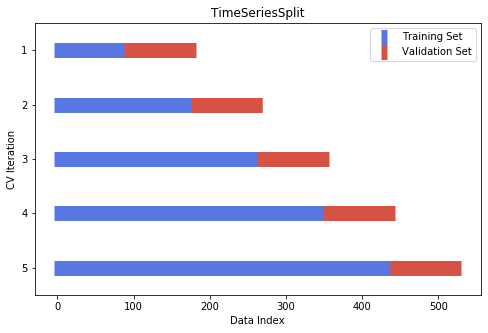

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))

for ii, (tr, tt) in enumerate(tscv.split(X, y)):
    l1 = ax.scatter(tr, [ii+1] * len(tr), c=[plt.cm.coolwarm(.1)], marker='_', lw=15)
    l2 = ax.scatter(tt, [ii+1] * len(tt), c=[plt.cm.coolwarm(.9)], marker='_', lw=15)
    ax.set(ylim=[5.5, 0.5], title='TimeSeriesSplit', xlabel='Data Index', ylabel='CV Iteration')
    ax.legend([l1, l2], ['Training Set', 'Validation Set'])

In [25]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(logreg, X, y, cv=tscv)

print("Unscaled Logistic Regression with Cross Validation Accuracy: {:.2f}%".format(scores.mean()*100))

Unscaled Logistic Regression with Cross Validation Accuracy: 90.11%


In [26]:
X_std = StandardScaler().fit_transform(X)

scores = cross_val_score(logreg, X_std, y, cv=tscv)

print("Scaled Logistic Regression with Cross Validation Accuracy: {:.2f}%".format(scores.mean()*100))

Scaled Logistic Regression with Cross Validation Accuracy: 93.56%


In [27]:
scores = cross_val_score(tree, X, y, cv=tscv)

print("Unscaled Decision Tree Classifier with Cross Validation Accuracy: {:.2f}%".format(scores.mean()*100))

Unscaled Decision Tree Classifier with Cross Validation Accuracy: 79.54%


In [28]:
scores = cross_val_score(tree, X_std, y, cv=tscv)

print("Scaled Decision Tree Classifier with Cross Validation Accuracy: {:.2f}%".format(scores.mean()*100))

Scaled Decision Tree Classifier with Cross Validation Accuracy: 92.64%
